In [1]:
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import cv2
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify

import numpy as np

## Helper function

In [2]:
def padder(image, patch_size):
    h = image.shape[0]
    w = image.shape[1]
    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w

    top_padding = int(height_padding/2)
    bottom_padding = height_padding - top_padding

    left_padding = int(width_padding/2)
    right_padding = width_padding - left_padding

    padded_image = cv2.copyMakeBorder(image, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    return padded_image

## Loading the data in patches

In [3]:
# Set the paths and directories
patch_dir = 'data_patched'

# Define patch size
patch_size = 256

### Train

In [4]:
# Data augmentation for the training set
train_image_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True  # Add horizontal flip for augmentation
)

train_image_generator = train_image_datagen.flow_from_directory(
    f'{patch_dir}/train_images',
    target_size=(patch_size, patch_size),
    batch_size=32,
    class_mode=None,
    color_mode='grayscale',
    seed=42)

# Training masks
train_mask_datagen = ImageDataGenerator(
    horizontal_flip=True
)

train_mask_generator = train_mask_datagen.flow_from_directory(
    f'{patch_dir}/train_masks_root',
    target_size=(patch_size, patch_size),
    batch_size=32,
    class_mode=None,
    color_mode='grayscale',
    seed=42)

train_generator = zip(train_image_generator, train_mask_generator)

Found 7744 images belonging to 1 classes.
Found 7744 images belonging to 1 classes.


### Validation

In [5]:
# Data augmentation for the test set
val_image_datagen = ImageDataGenerator(rescale=1./255,    
                                       horizontal_flip=True  # Add horizontal flip for augmentation
)

val_image_generator = val_image_datagen.flow_from_directory(
    f'{patch_dir}/val_images',
    target_size=(patch_size, patch_size),
    batch_size=32,
    class_mode=None,
    color_mode='grayscale',
    seed=42)

# Test masks
val_mask_datagen = ImageDataGenerator(
    horizontal_flip=True  # Add horizontal flip for augmentation
)

val_mask_generator = val_mask_datagen.flow_from_directory(
    f'{patch_dir}/val_masks_root',
    target_size=(patch_size, patch_size),
    batch_size=32,
    class_mode=None,
    color_mode='grayscale',
    seed=42)

val_generator = zip(val_image_generator, val_mask_generator)

Found 1815 images belonging to 1 classes.
Found 1815 images belonging to 1 classes.


### Test

In [6]:
# Data augmentation for the test set
test_image_datagen = ImageDataGenerator(rescale=1./255)

test_image_generator = test_image_datagen.flow_from_directory(
    f'{patch_dir}/test_images',
    target_size=(patch_size, patch_size),
    batch_size=32,
    class_mode=None,
    color_mode='grayscale',
    seed=42)

# Test masks
test_mask_datagen = ImageDataGenerator()

test_mask_generator = test_mask_datagen.flow_from_directory(
    f'{patch_dir}/test_masks_root',
    target_size=(patch_size, patch_size),
    batch_size=32,
    class_mode=None,
    color_mode='grayscale',
    seed=42)

test_generator = zip(test_image_generator, test_mask_generator)

Found 2904 images belonging to 1 classes.
Found 2904 images belonging to 1 classes.


## Model architecture

In [7]:
import tensorflow as tf
import keras.backend as K

In [8]:
# Let's implement two custom metrics f1 score and iou
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [9]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        threshold = 0.5 
        y_pred_binary = K.round(y_pred + 0.5 - threshold)
        
        intersection = K.sum(K.abs(y_true * y_pred_binary), axis=[1,2,3])
        total = K.sum(K.square(y_true), [1,2,3]) + K.sum(K.square(y_pred_binary), [1,2,3])
        union = total - intersection
        return (intersection + K.epsilon()) / (union + K.epsilon())
    
    return K.mean(f(y_true, y_pred), axis=-1)

In [10]:
# U-Net model
# Author: Sreenivas Bhattiprolu
# This code is coming from the videos at the beginning
from keras.models import Model
import keras.backend as K
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
# Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    # Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1, iou])
    model.summary()
    
    return model

## Model trainning

In [11]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the model
model = simple_unet_model(256, 256, 1)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_iou', mode = 'max', patience=55, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('root_4.h5', monitor='val_iou', mode = 'max', save_best_only=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [12]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_image_generator),  # Use len(train_image_generator) instead
    epochs=200,  # Adjust the number of epochs as needed
    validation_data=val_generator,
    validation_steps=len(val_image_generator),  # Use len(val_image_generator) instead
    callbacks=[early_stopping]
)

Epoch 1/200
242/242 [==============================] - 110s 395ms/step - loss: 0.0765 - accuracy: 0.9749 - f1: 0.0010 - iou: 0.4452 - val_loss: 0.0349 - val_accuracy: 0.9927 - val_f1: 0.0000e+00 - val_iou: 0.7280
Epoch 2/200
242/242 [==============================] - 56s 230ms/step - loss: 0.0292 - accuracy: 0.9926 - f1: 0.2814 - iou: 0.5956 - val_loss: 0.0220 - val_accuracy: 0.9948 - val_f1: 0.5417 - val_iou: 0.5727
Epoch 3/200
242/242 [==============================] - 56s 233ms/step - loss: 0.0190 - accuracy: 0.9944 - f1: 0.6062 - iou: 0.5491 - val_loss: 0.0130 - val_accuracy: 0.9958 - val_f1: 0.6488 - val_iou: 0.7635
Epoch 4/200
242/242 [==============================] - 56s 232ms/step - loss: 0.0126 - accuracy: 0.9956 - f1: 0.7089 - iou: 0.6582 - val_loss: 0.0090 - val_accuracy: 0.9967 - val_f1: 0.7474 - val_iou: 0.7848
Epoch 5/200
242/242 [==============================] - 56s 233ms/step - loss: 0.0101 - accuracy: 0.9962 - f1: 0.7604 - iou: 0.7697 - val_loss: 0.0110 - val_accurac

## Evaluation

In [13]:
import plotly.graph_objects as go
import plotly.offline as pyo

In [14]:
# Assuming history object has information about loss, val_loss, iou, and val_iou
loss = history.history['loss']
val_loss = history.history['val_loss']
iou = history.history['iou']
val_iou = history.history['val_iou']

epochs = range(1, len(loss) + 1)
epochs_list = list(epochs)  # Convert range to list

# Plotting the training and validation loss
fig_loss = go.Figure()

fig_loss.add_trace(go.Scatter(x=epochs_list, y=loss, mode='lines', name='Training Loss'))
fig_loss.add_trace(go.Scatter(x=epochs_list, y=val_loss, mode='lines', name='Validation Loss'))

fig_loss.update_layout(title='Training and Validation Loss',
                       xaxis_title='Epoch',
                       yaxis_title='Loss',
                       legend=dict(x=0, y=1, traceorder='normal'))

fig_loss.show()

# Save the plot as an HTML file
pyo.plot(fig_loss, filename='training_validation_loss.html')

'training_validation_loss.html'

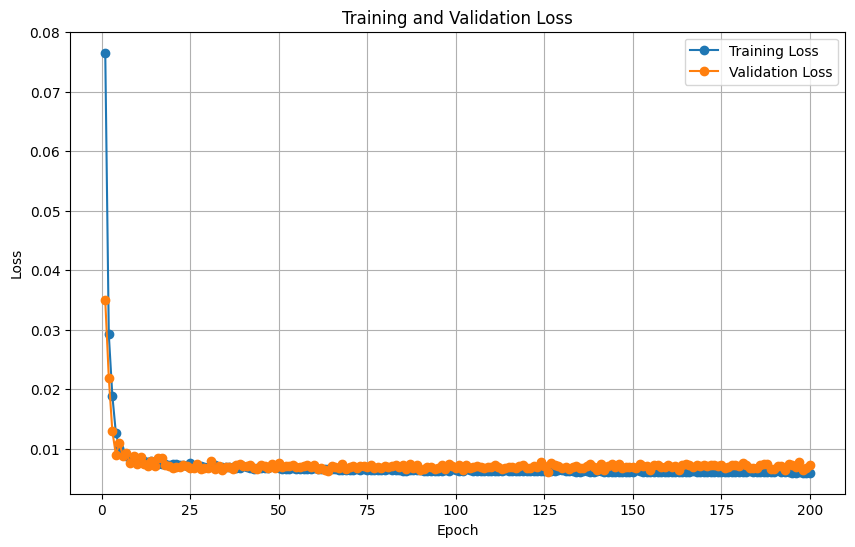

In [15]:
import matplotlib.pyplot as plt

# Assuming history object has information about loss, val_loss, iou, and val_iou
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
epochs_list = list(epochs)  # Convert range to list

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs_list, loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs_list, val_loss, label='Validation Loss', marker='o', linestyle='-')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [16]:
best_epoch = np.argmin(history.history['val_loss']) + 1
best_val_loss = np.min(history.history['val_loss'])

print(f"The best model is from epoch {best_epoch} with validation loss: {best_val_loss}")


The best model is from epoch 126 with validation loss: 0.006143421865999699


In [17]:
# Plotting the training and validation IoU
fig_iou = go.Figure()

fig_iou.add_trace(go.Scatter(x=epochs_list, y=iou, mode='lines', name='Training IoU'))
fig_iou.add_trace(go.Scatter(x=epochs_list, y=val_iou, mode='lines', name='Validation IoU'))

fig_iou.update_layout(title='Training and Validation IoU',
                      xaxis_title='Epoch',
                      yaxis_title='IoU',
                      legend=dict(x=0, y=1, traceorder='normal'))

fig_iou.show()

# Save the plot as an HTML file
pyo.plot(fig_iou, filename='training_validation_iou.html')

'training_validation_iou.html'

In [18]:
best_epoch = np.argmax(history.history['val_iou']) + 1
best_val_loss = np.max(history.history['val_iou'])

print(f"The best model is from epoch {best_epoch} with validation loss: {best_val_loss}")

The best model is from epoch 155 with validation loss: 0.9023675322532654


## Error analysis

In [19]:
# Evaluate the model on the test set
score = model.evaluate(test_generator, steps=len(test_image_generator))

# Print the evaluation metrics
print(f'Test Loss: {score[0]}')
print(f'Test Accuracy: {score[1]}')
print(f'Test F1 Score: {score[2]}')
print(f'Test IoU: {score[3]}')

91/91 [==============================] - 33s 359ms/step - loss: 0.0069 - accuracy: 0.9973 - f1: 0.8191 - iou: 0.9029
Test Loss: 0.006946456618607044
Test Accuracy: 0.9973463416099548
Test F1 Score: 0.8191097974777222
Test IoU: 0.9028586745262146


In [20]:
# Save the best model
model.save(f"root_4.h5")

In [21]:
from keras.models import load_model

# Load the best model saved during training, providing custom metrics
model = load_model("root_2.h5", custom_objects={'f1': f1, 'iou': iou})

(1, 256, 256, 1)
1/1 [==============================] - 1s 799ms/step


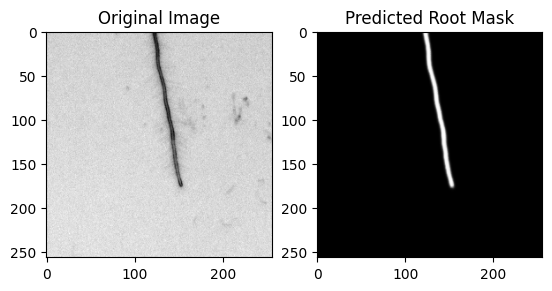

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Load the first image from the test set
test_image_path = 'data_patched/test_images/test/031_43-6-ROOT1-2023-08-08_control_pH7_-Fe+B_f6h1_02-Fish Eye Corrected_25.png'
img = image.load_img(test_image_path, target_size=(patch_size, patch_size), color_mode='grayscale')
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize pixel values to be between 0 and 1
print(img_array.shape)

# Predict the mask using the model
predicted_mask = model.predict(img_array)

# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(img_array[0, :, :, 0], cmap='gray')
plt.title('Original Image')

# Plot the predicted root mask
plt.subplot(1, 2, 2)
plt.imshow(predicted_mask[0, :, :, 0], cmap='gray')
plt.title('Predicted Root Mask')

plt.show()


4/4 [==============================] - 2s 535ms/step


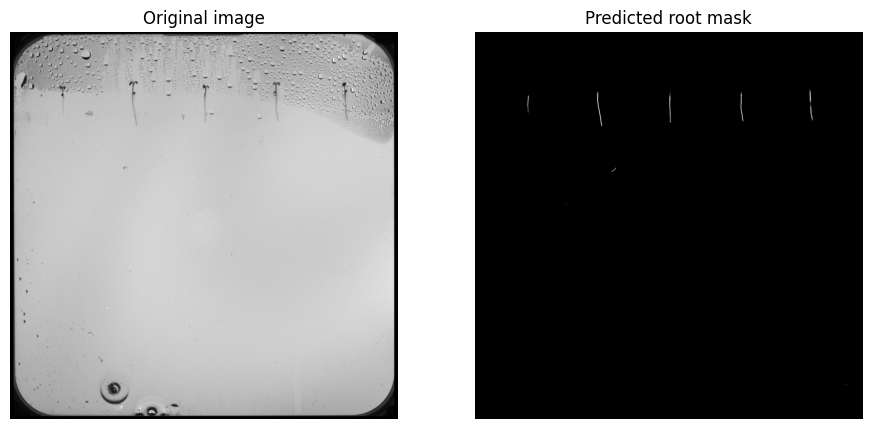

In [23]:
image = cv2.imread("cropped_data/test_images_cropped/test/031_43-6-ROOT1-2023-08-08_control_pH7_-Fe+B_f6h1_02-Fish Eye Corrected.png", cv2.IMREAD_GRAYSCALE)

patch_size = 256

image = padder(image, 256)

patches = patchify(image, (patch_size, patch_size), step=patch_size)

i = patches.shape[0]
j = patches.shape[1]

patches = patches.reshape(-1, patch_size, patch_size, 1)

preds = model.predict(patches/255)

preds = preds.reshape(i, j, 256, 256)

predicted_mask = unpatchify(preds, (image.shape[0], image.shape[1]))

fig, ax = plt.subplots(1, 2, figsize=(11, 6))
ax[0].imshow(image, cmap="gray")
ax[1].imshow(predicted_mask, cmap="gray")
ax[0].axis("off")
ax[0].set_title("Original image")
ax[1].axis("off")
ax[1].set_title("Predicted root mask")

plt.show()

In [24]:
def process_images_in_folder(folder_path, num_images):
    # Get a list of all image files in the specified folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

    # Select a random sample of image files
    selected_files = np.random.choice(image_files, num_images, replace=False)

    for image_file in selected_files:
        # Construct the full path of the image file
        image_path = os.path.join(folder_path, image_file)

        # Read the image
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Apply your existing code
        patch_size = 256
        image = padder(image, 256)
        patches = patchify(image, (patch_size, patch_size), step=patch_size)
        i, j = patches.shape[0], patches.shape[1]
        patches = patches.reshape(-1, patch_size, patch_size, 1)
        preds = model.predict(patches / 255)
        preds = preds.reshape(i, j, 256, 256)
        predicted_mask = unpatchify(preds, (image.shape[0], image.shape[1]))

        # Plot the images with the image file name as the title
        fig, ax = plt.subplots(1, 2, figsize=(11, 6))
        ax[0].imshow(image, cmap="gray")
        ax[1].imshow(predicted_mask, cmap="gray")
        ax[0].axis("off")
        ax[0].set_title("Original image")
        ax[1].axis("off")
        ax[1].set_title(f"Predicted root mask - {image_file}")

        plt.show()

4/4 [==============================] - 0s 62ms/step


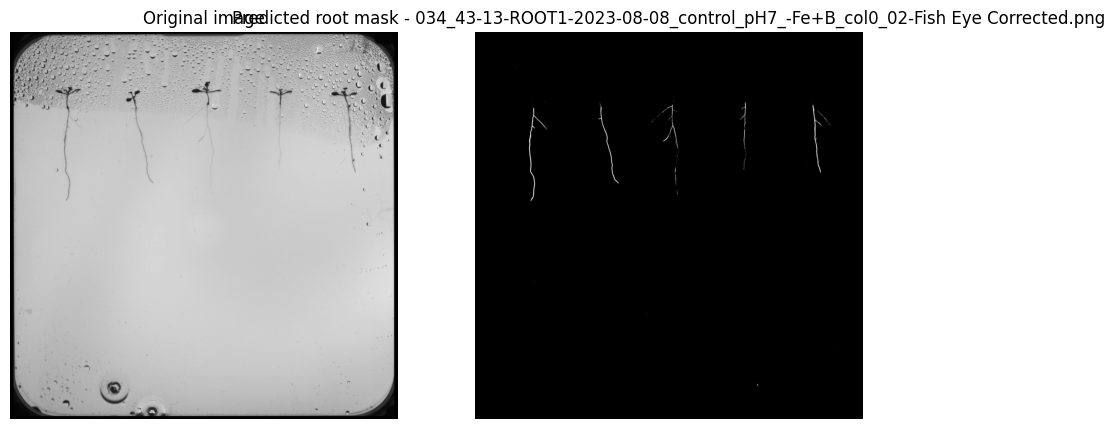

4/4 [==============================] - 0s 62ms/step


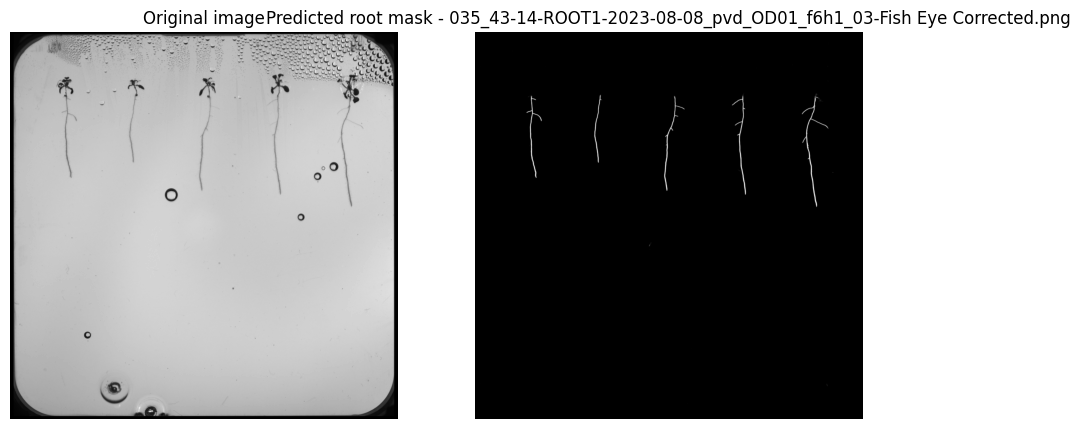

4/4 [==============================] - 0s 62ms/step


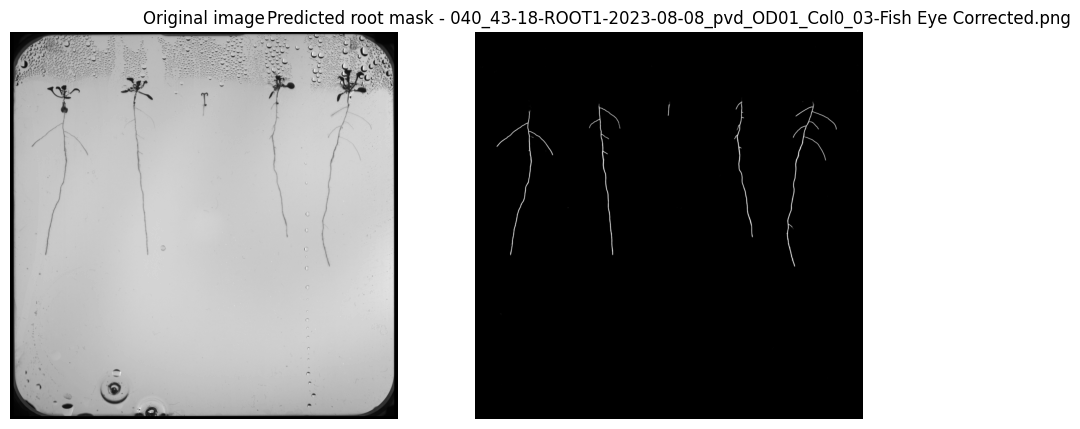

4/4 [==============================] - 0s 63ms/step


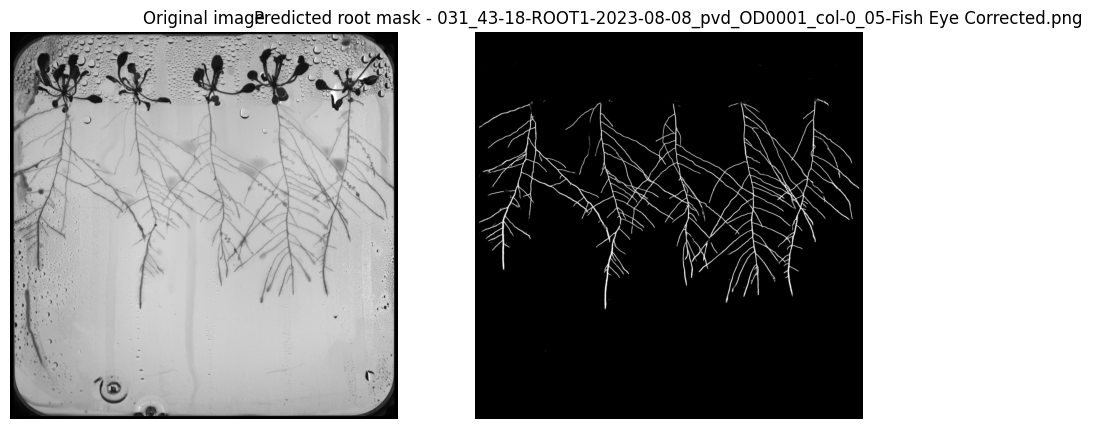

4/4 [==============================] - 0s 62ms/step


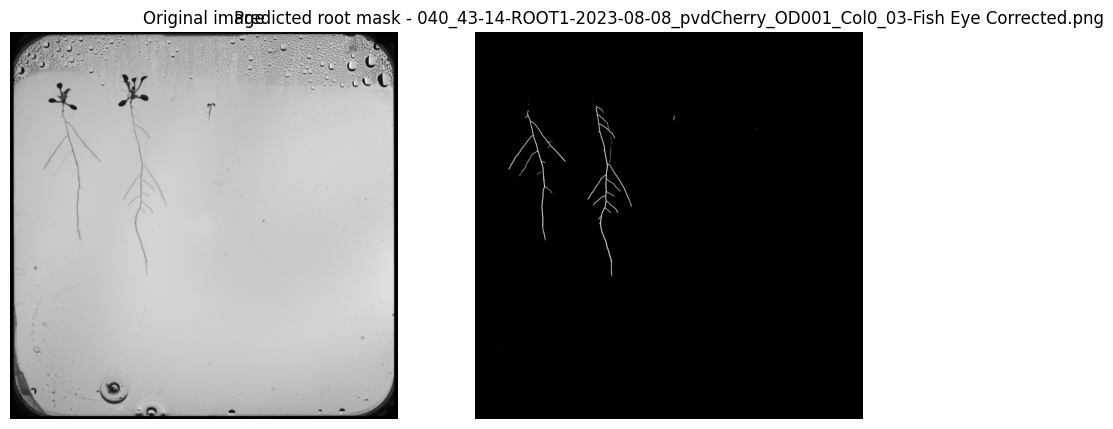

4/4 [==============================] - 0s 64ms/step


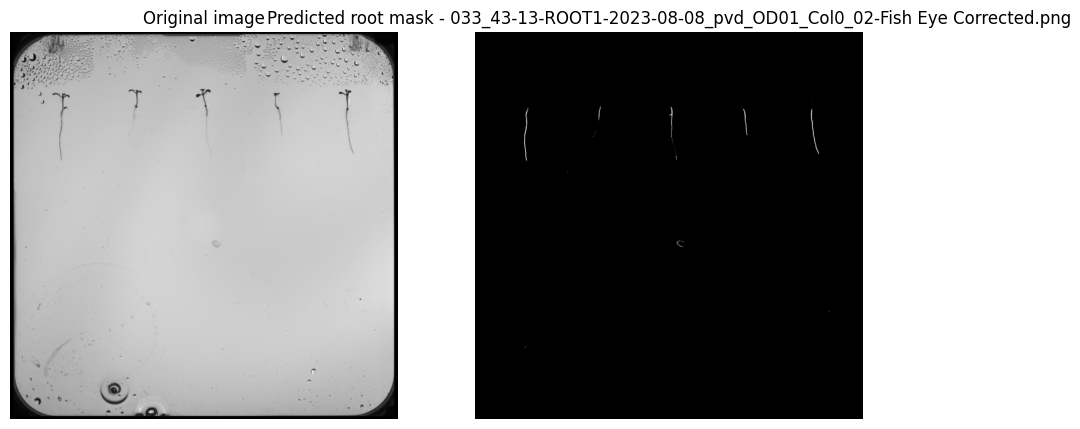

4/4 [==============================] - 0s 62ms/step


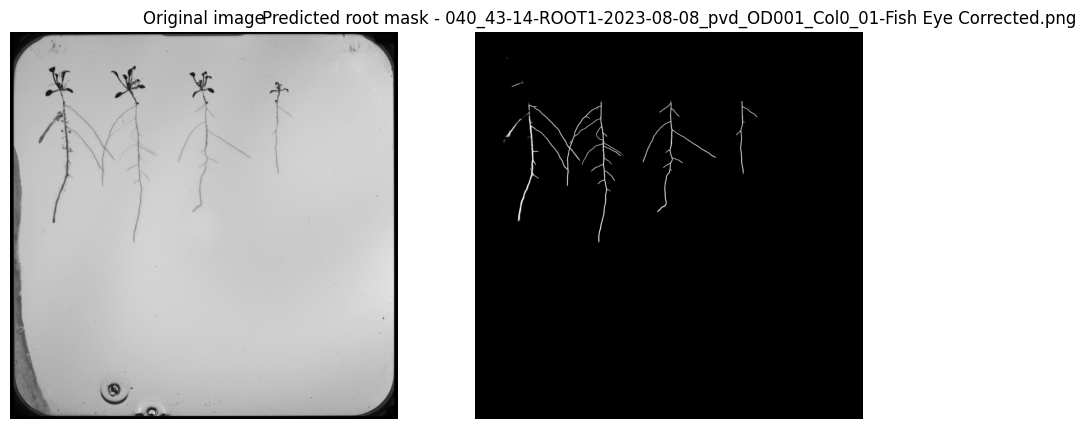

4/4 [==============================] - 0s 61ms/step


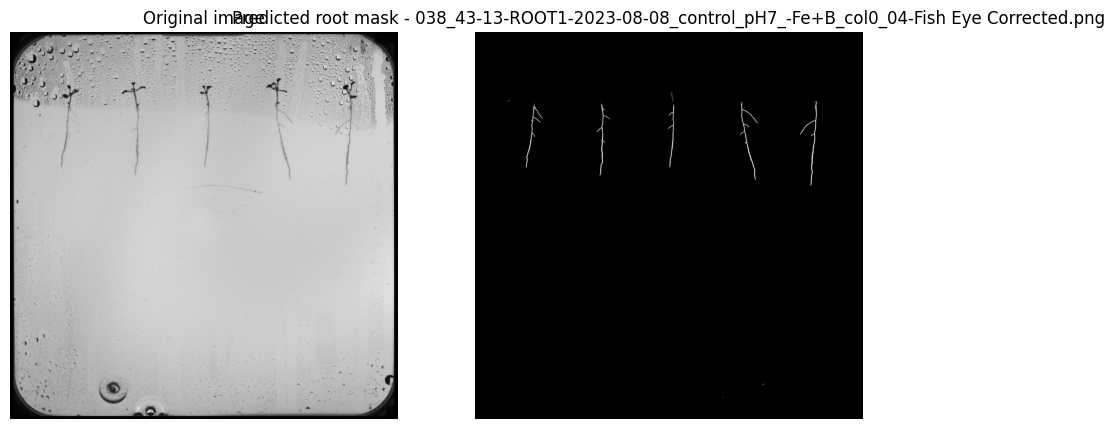

4/4 [==============================] - 0s 63ms/step


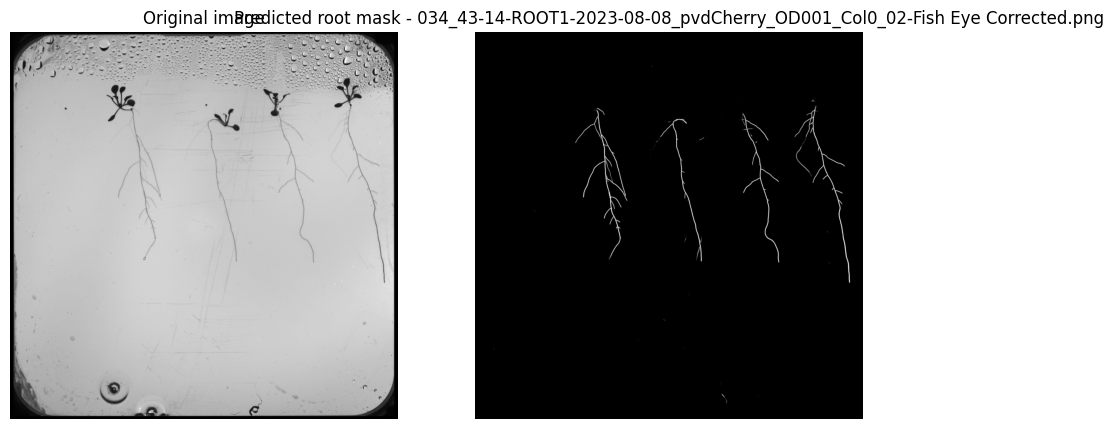

4/4 [==============================] - 0s 62ms/step


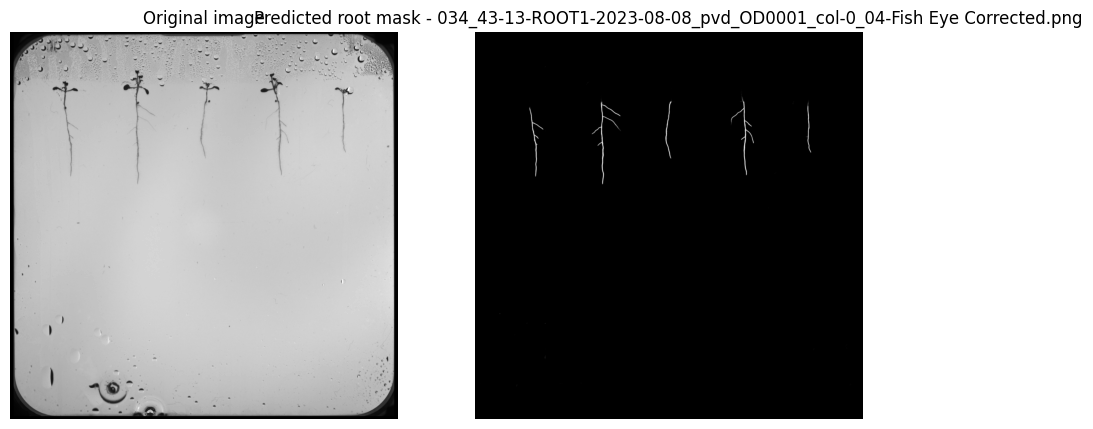

4/4 [==============================] - 0s 63ms/step


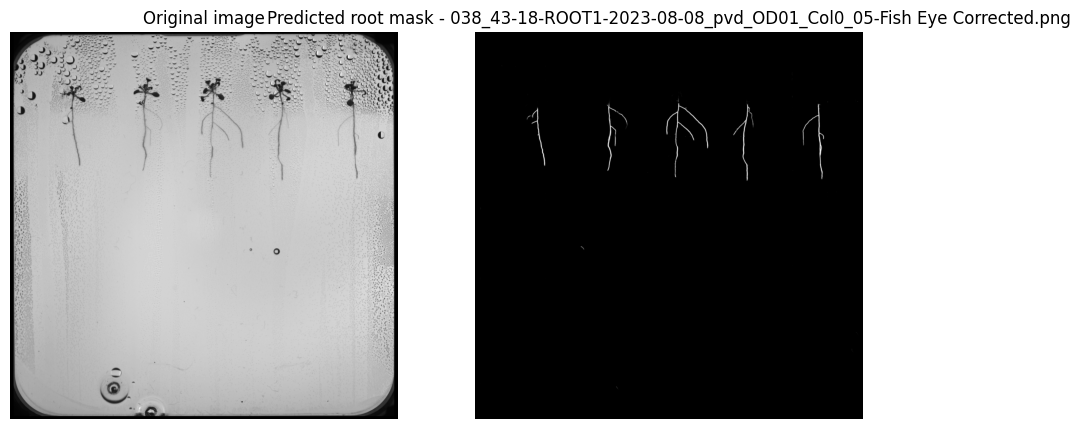

4/4 [==============================] - 0s 63ms/step


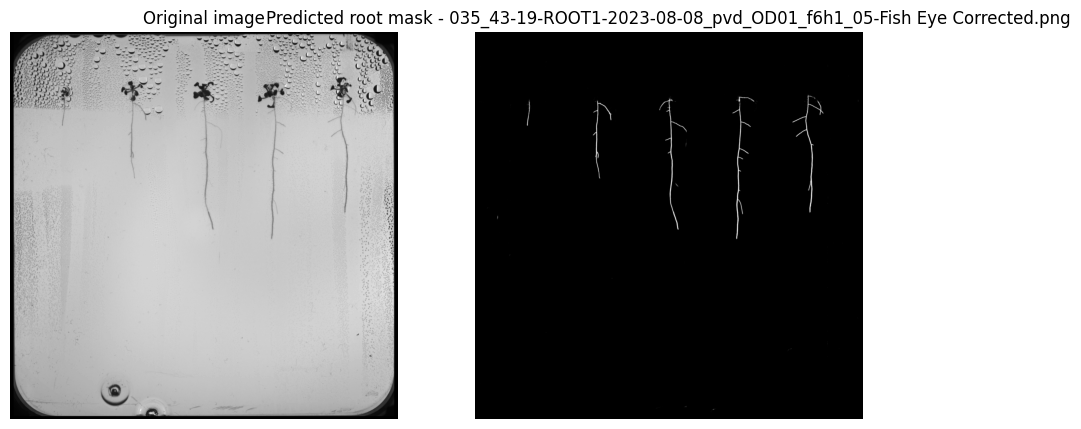

4/4 [==============================] - 0s 63ms/step


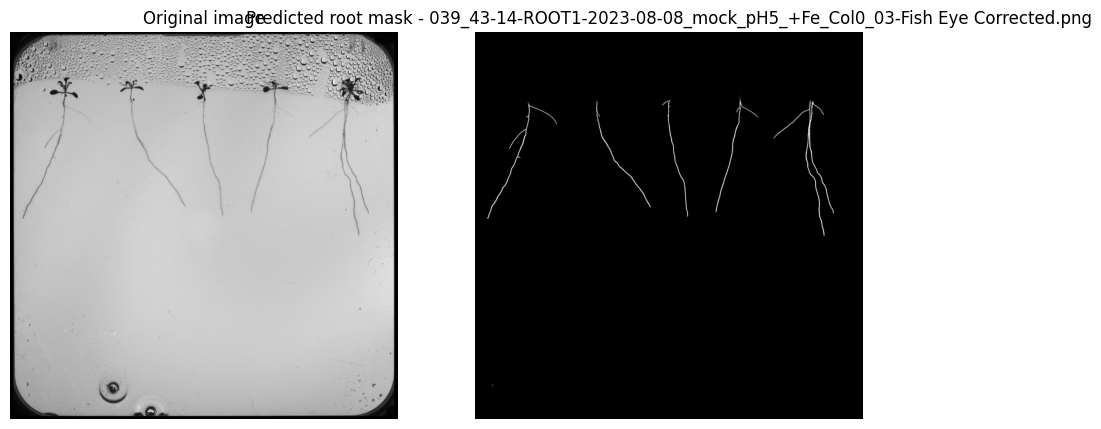

4/4 [==============================] - 0s 63ms/step


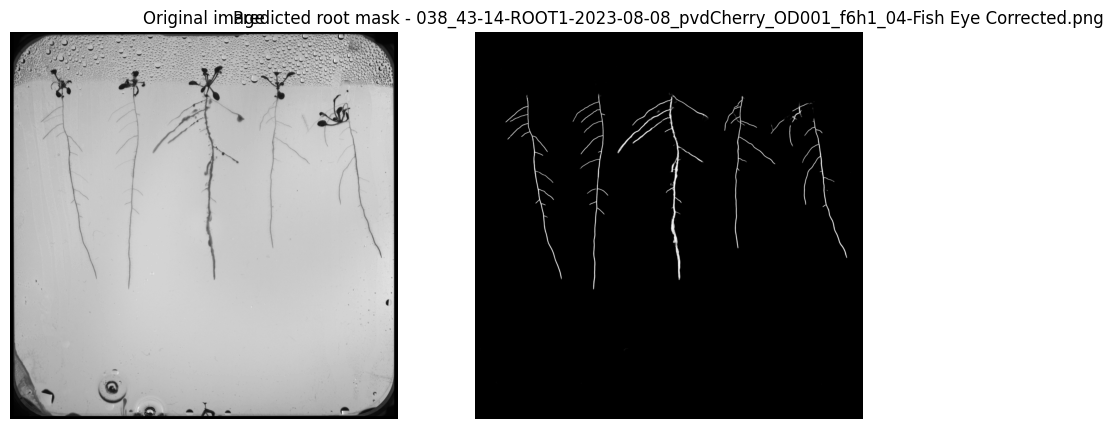

4/4 [==============================] - 0s 61ms/step


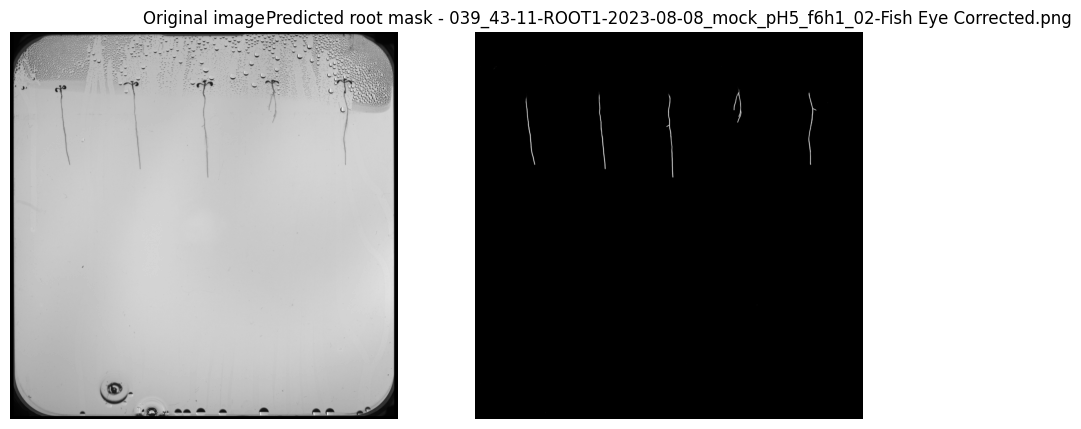

4/4 [==============================] - 0s 63ms/step


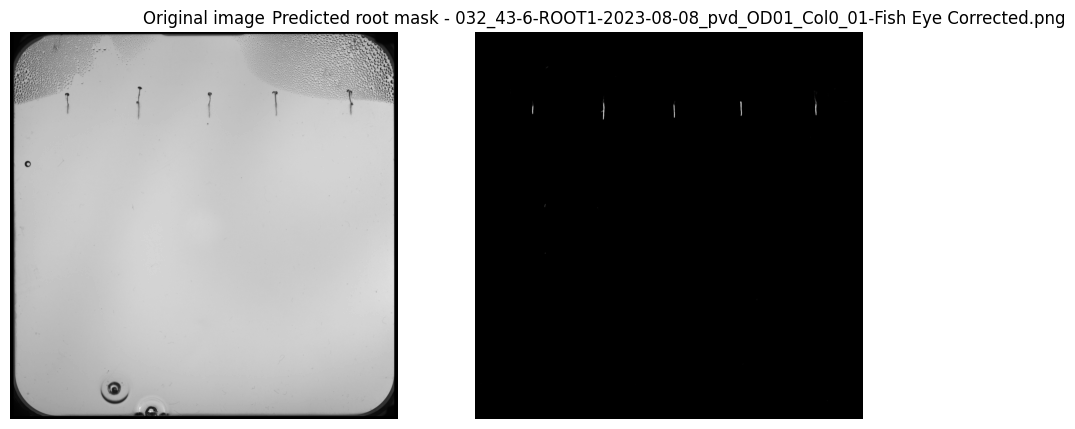

4/4 [==============================] - 0s 65ms/step


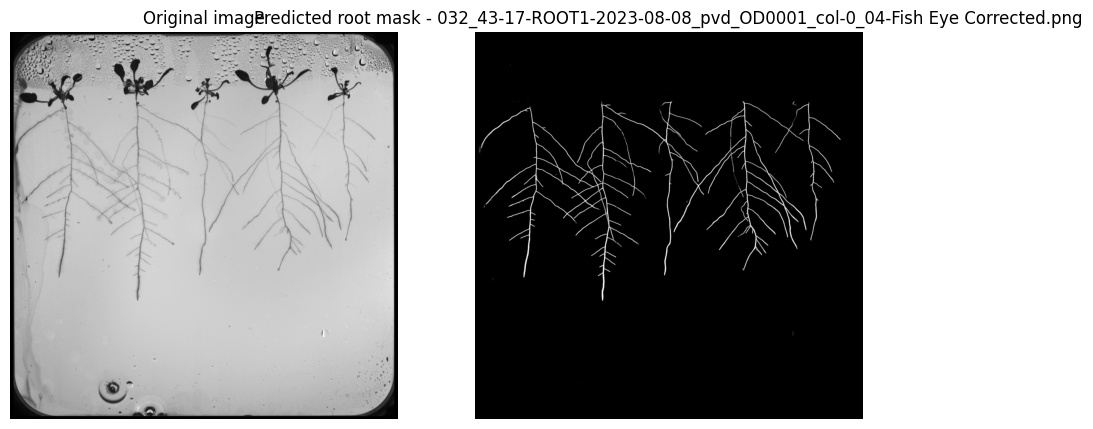

4/4 [==============================] - 0s 63ms/step


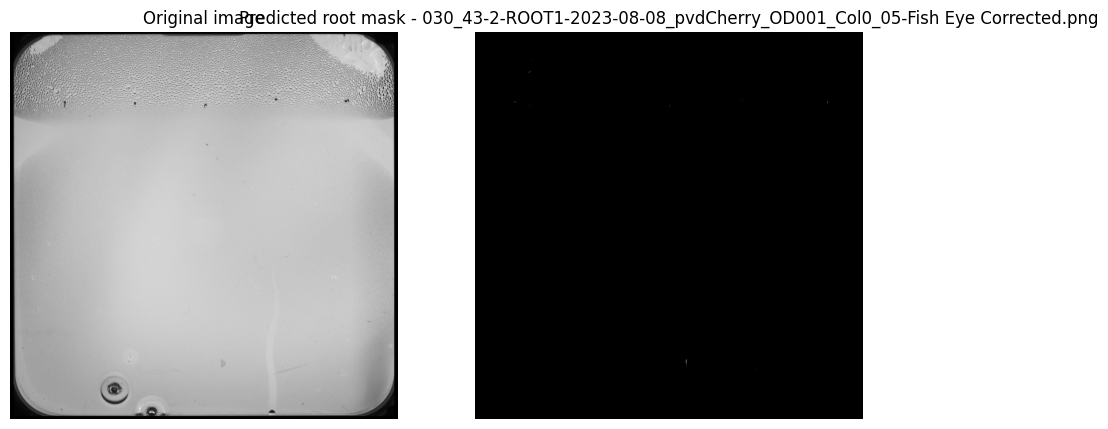

4/4 [==============================] - 0s 60ms/step


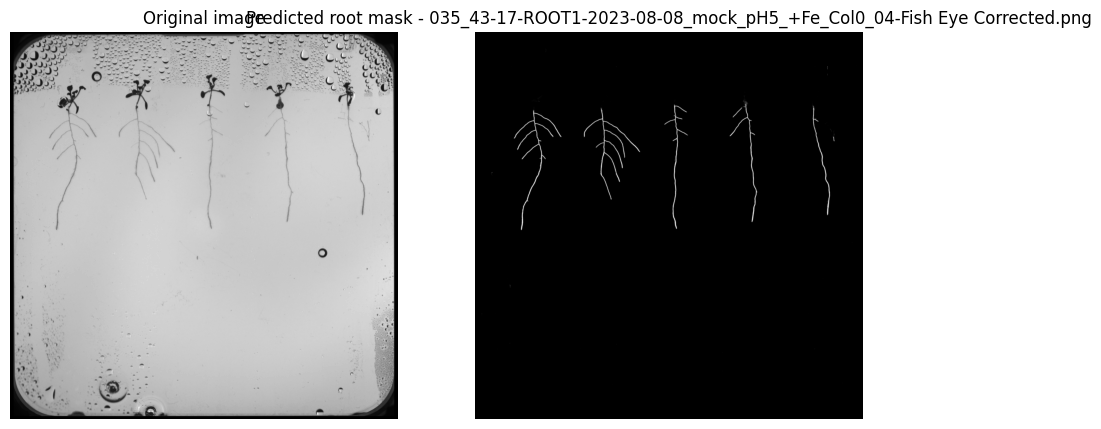

4/4 [==============================] - 0s 65ms/step


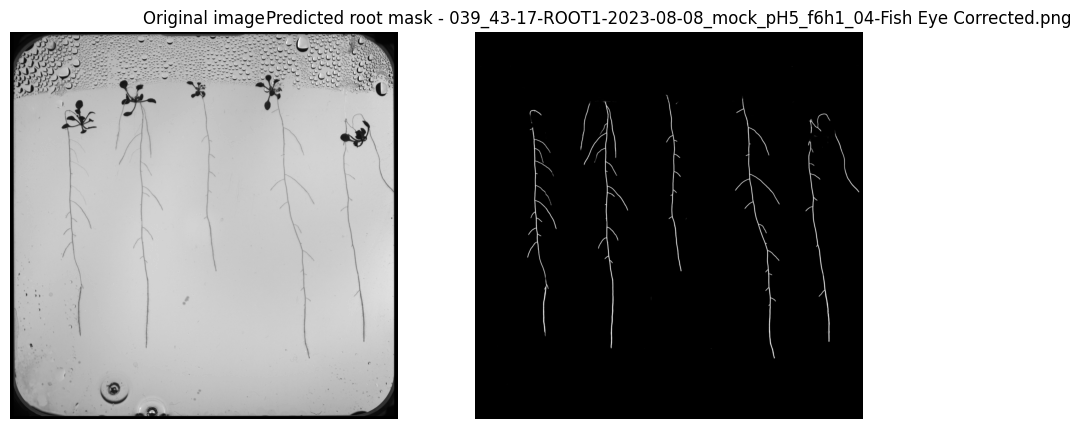

4/4 [==============================] - 0s 63ms/step


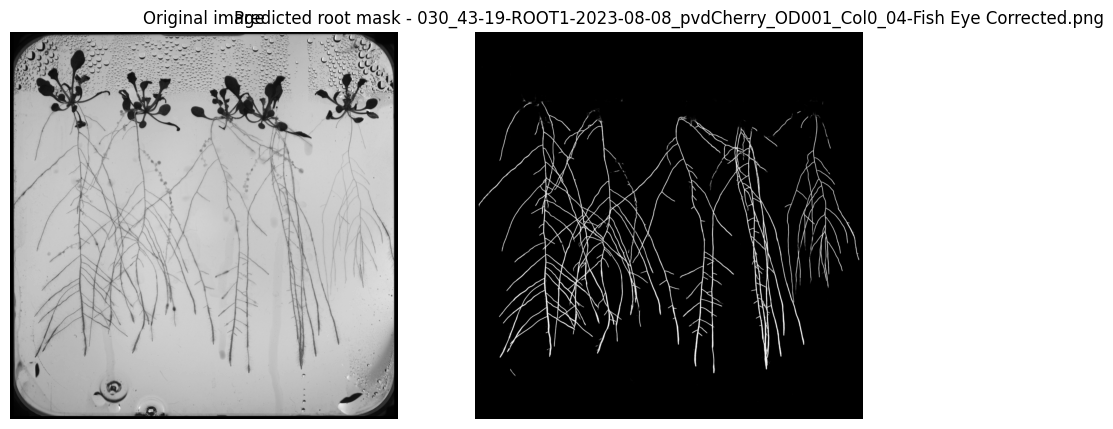

4/4 [==============================] - 0s 64ms/step


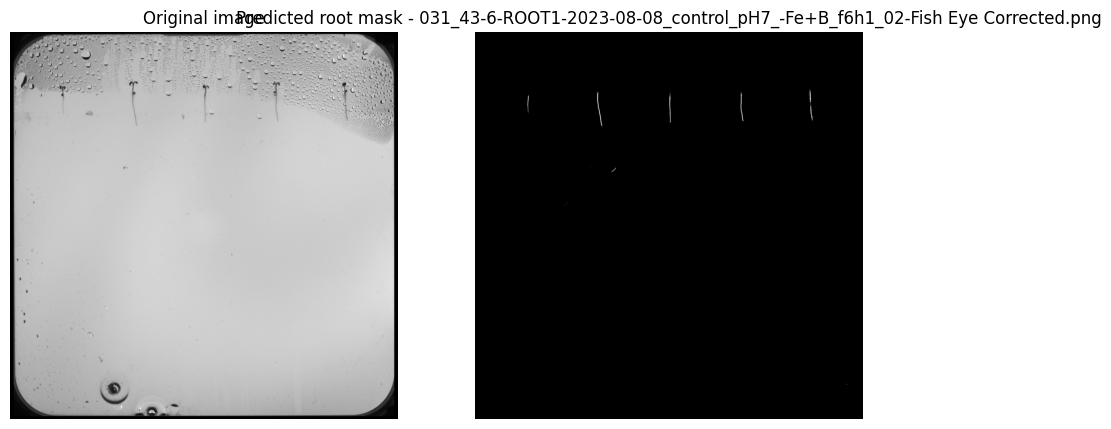

4/4 [==============================] - 0s 61ms/step


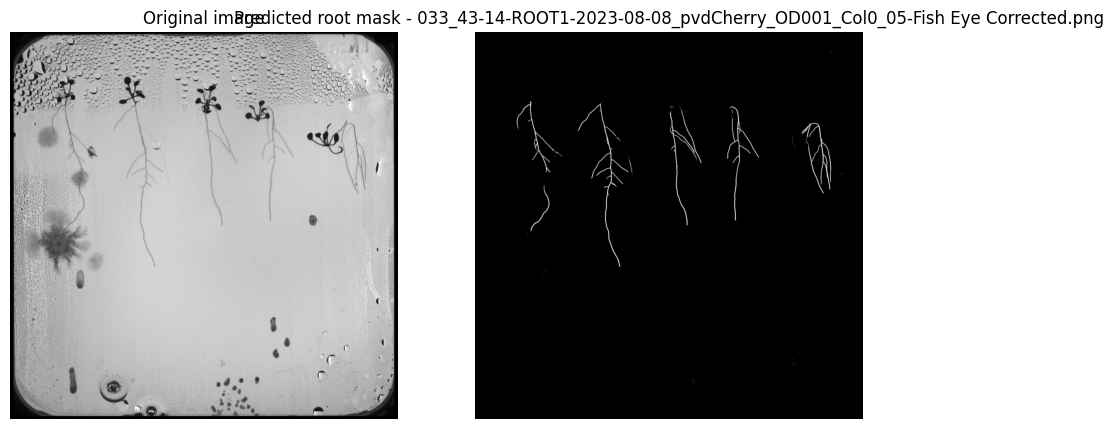

4/4 [==============================] - 0s 61ms/step


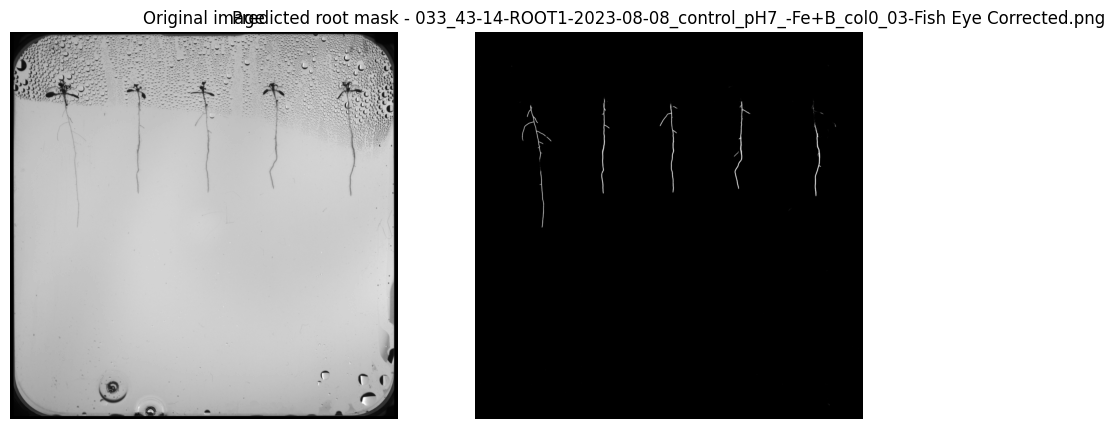

In [25]:
folder_path = 'cropped_data/test_images_cropped/test'
num_images = 24

process_images_in_folder(folder_path, num_images)
